# Modeling Hodking-Huxely with latent neural ODEs  

In this example will show how to use the latentUDE framework to model a Hodking-Huxely neuron with dynamic synaptic inputs. 

In [1]:
using Pkg, Revise, Lux, Random, DifferentialEquations, SciMLSensitivity, ComponentArrays, Plots, MLUtils, OptimizationOptimisers, LinearAlgebra, Statistics, Printf, DiffEqGPU
using IterTools: ncycle
using BenchmarkTools
using NeuroDynamics
using LuxCUDA

In [2]:
device = "cpu"
const dev = device == "gpu" ? gpu_device() : cpu_device()


(::LuxCPUDevice) (generic function with 5 methods)

In [3]:
CUDA.versioninfo()

CUDA runtime 12.2, artifact installation
CUDA driver 12.5
NVIDIA driver 535.113.1, originally for CUDA 12.2

CUDA libraries: 
- CUBLAS: 12.2.5
- CURAND: 10.3.3
- CUFFT: 11.0.8
- CUSOLVER: 11.5.2
- CUSPARSE: 12.1.2
- CUPTI: 2023.2.2 (API 20.0.0)
- NVML: 12.0.0+535.113.1

Julia packages: 
- CUDA: 5.4.3
- CUDA_Driver_jll: 0.9.1+1
- CUDA_Runtime_jll: 0.14.1+0

Toolchain:
- Julia: 1.10.4
- LLVM: 15.0.7

Preferences:
- CUDA_Runtime_jll.version: 12.2

1 device:
  0: NVIDIA A100 80GB PCIe (sm_80, 78.698 GiB / 80.000 GiB available)



## 1.Generating ground truth data 


### 1.1 Simulating Synaptic Inputs 

We will use the [Tsodyks-Markram model](https://www.pnas.org/doi/full/10.1073/pnas.94.2.719) to simulate the synaptic inputs to a neuron. We will generate multiple trajectories to later drive our Hodking-Huxley neuron model.

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


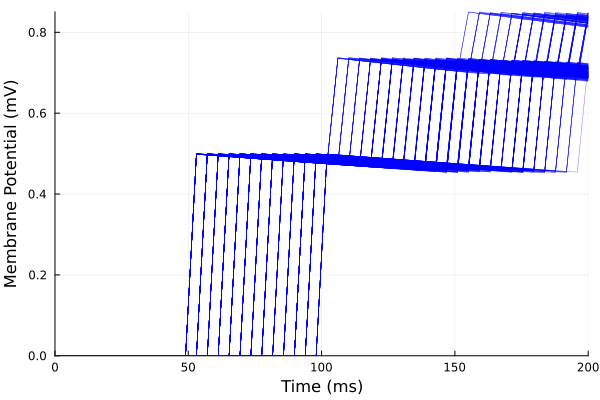

In [4]:
n_samples = 512
tspan = (0.0f0, 200.0f0)
ts = range(tspan[1], tspan[2], length=50)
ts = ts |> Array{Float32}
p =  [30, 1000, 50, 0.5, 0.005]
function TMS(x, p, t)
    v, R, gsyn = x
    tau, tau_u, tau_R, v0, gmax = p 
    dx₁ = -(v / tau_u)
    dx₂ = (1 - R) / tau_R
    dx₃ = -(gsyn / tau)
    return vcat(dx₁, dx₂, dx₃)
end

function epsp!(integrator)
    integrator.u[1] += integrator.p[4] * (1 - integrator.u[1])
    integrator.u[3] += integrator.p[5] * integrator.u[1] * integrator.u[2]
    integrator.u[2] -= integrator.u[1] * integrator.u[2]
end
prob = ODEProblem(TMS, [0.0, 1.0, 0.0], tspan, p)
function prob_func(prob, i, repeat)
    t_start = rand(50:100)
    t_int = rand(50:100)
    t_end = rand(400:450)
    epsp_ts = PresetTimeCallback(t_start:t_int:t_end, epsp!, save_positions=(false, false))
    remake(prob, callback=epsp_ts)
end

ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
U = solve(ensemble_prob, Tsit5(),  EnsembleThreads(); saveat=ts, trajectories=n_samples);
plot(U, vars=(1), alpha=0.5, color=:blue, lw=0.5, legend=false, xlabel="Time (ms)", ylabel="Membrane Potential (mV)")


### 1.2 Simulating a Hodgkin-Huxley Neuron 

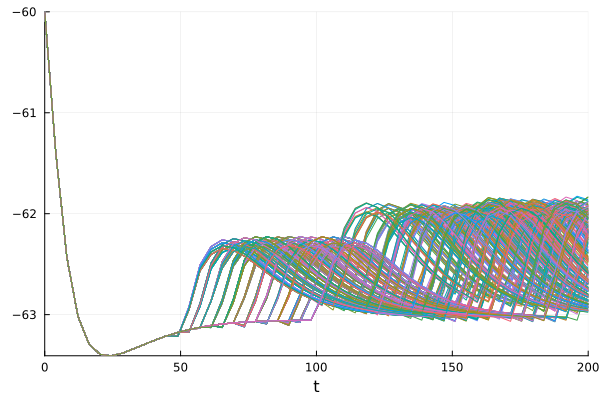

In [5]:
# Potassium ion-channel rate functions
alpha_n(v) = (0.02 * (v - 25.0)) / (1.0 - exp((-1.0 * (v - 25.0)) / 9.0))
beta_n(v) = (-0.002 * (v - 25.0)) / (1.0 - exp((v - 25.0) / 9.0))

# Sodium ion-channel rate functions
alpha_m(v) = (0.182 * (v + 35.0)) / (1.0 - exp((-1.0 * (v + 35.0)) / 9.0))
beta_m(v) = (-0.124 * (v + 35.0)) / (1.0 - exp((v + 35.0) / 9.0))

alpha_h(v) = 0.25 * exp((-1.0 * (v + 90.0)) / 12.0)
beta_h(v) = (0.25 * exp((v + 62.0) / 6.0)) / exp((v + 90.0) / 12.0)



function HH(x, p, t, u)
    gK, gNa, gL, EK, ENa, EL, C, ESyn, i = p
    v, n, m, h = x
    ISyn(t) = u[i](t)[end] * (ESyn - v)

    dx₁ = ((gK * (n^4.0) * (EK - v)) + (gNa * (m^3.0) * h * (ENa - v)) + (gL * (EL - v)) + ISyn(t)) / C
    dx₂ = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    dx₃ = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    dx₄ = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)

    dx = vcat(dx₁, dx₂, dx₃, dx₄)
end

dxdt(x, p, t) = HH(x, p, t, U)

p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 1] 
# n, m & h steady-states
n_inf(v) = alpha_n(v) / (alpha_n(v) + beta_n(v))
m_inf(v) = alpha_m(v) / (alpha_m(v) + beta_m(v))
h_inf(v) = alpha_h(v) / (alpha_h(v) + beta_h(v))

v0 = -60
x0 = [v0, n_inf(v0), m_inf(v0), h_inf(v0)]
prob = ODEProblem(dxdt, x0, tspan, p)
prob_func(prob, i, repeat) = remake(prob, p=(p[1:end-1]..., i))
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
Y = solve(ensemble_prob, EnsembleThreads(); saveat=ts, trajectories=n_samples)
plot(Y, vars=1, label="v")


### 1.3 Creating a dataset and splitting it into train val test sets

In [6]:
Y_data = Array(Y) .|> Float32
U_data = Array(U) .|> Float32
input_dim = size(U_data)[1]
obs_dim = size(Y_data)[1]
(u_train, y_train), (u_val, y_val) = splitobs((U_data, Y_data); at=0.8, shuffle=true)
# Create dataloaders
train_loader = DataLoader((U_data, Y_data), batchsize=256, shuffle=false)
val_loader = DataLoader((U_data, Y_data), batchsize=64, shuffle=true);


## 2. Creating the model 

In [7]:
function create_model(n_states, ctrl_dim, obs_dim, context_dim, t_init, ts, device)
    rng = Random.MersenneTwister(1234)
    obs_encoder = Recurrent_Encoder(obs_dim, n_states, context_dim, 32, t_init)
    vector_field = Chain(Dense(n_states+ctrl_dim, 32, tanh), Dense(32, n_states, tanh))
    dynamics = ODE(vector_field, Euler(); saveat=ts, dt=(ts[2]-ts[1]))
    obs_decoder = Linear_Decoder(n_states, obs_dim, "None")   

    model = LatentUDE(obs_encoder=obs_encoder, dynamics=dynamics, obs_decoder=obs_decoder, device=device)
    p, st = Lux.setup(rng, model)
    p = p |> ComponentArray{Float32} |> device
    st = st |> device
    return model, p, st
end

create_model (generic function with 1 method)

In [8]:
latent_dim = 4
context_dim = 0 # No need for context if we have ODE dynamics
t_init = 50
model, p, st = create_model(latent_dim, input_dim, obs_dim, context_dim, t_init, ts, dev)
u, y = first(train_loader) .|> dev


(Float32[0.0 0.0 … 0.70646477 0.7035871; 1.0 1.0 … 0.6458019 0.6735673; 0.0 0.0 … 0.00094518706 0.0008249547;;; 0.0 0.0 … 0.70159715 0.69873935; 1.0 1.0 … 0.6479325 0.67553097; 0.0 0.0 … 0.0009791895 0.0008546317;;; 0.0 0.0 … 0.69809794 0.6952544; 1.0 1.0 … 0.68143624 0.7064083; 0.0 0.0 … 0.0008288656 0.0007234302;;; … ;;; 0.0 0.0 … 0.7049965 0.70212483; 1.0 1.0 … 0.6304584 0.6594265; 0.0 0.0 … 0.0010448399 0.00091193983;;; 0.0 0.0 … 0.6968657 0.6940271; 1.0 1.0 … 0.7319743 0.7529845; 0.0 0.0 … 0.0005928456 0.00051744934;;; 0.0 0.0 … 0.69348675 0.69066197; 1.0 1.0 … 0.717954 0.7400634; 0.0 0.0 … 0.00067897537 0.000592608], Float32[-60.0 -61.39905 … -62.59967 -62.688614; 0.0007906538 0.0007572497 … 0.00060283445 0.00059579423; 0.083627336 0.07310405 … 0.06403164 0.06343353; 0.4174298 0.42288226 … 0.5156737 0.5176887;;; -60.0 -61.39905 … -62.56764 -62.66542; 0.0007906538 0.0007572497 … 0.0006060328 0.00059826614; 0.083627336 0.07310405 … 0.064248696 0.06359106; 0.4174298 0.42288226 … 0.5

In [9]:
@btime model(y, u, ts, p, st)

  103.383 ms (539501 allocations: 137.62 MiB)


(Float32[-1.7514565 -2.5999835 … 67.964714 69.51701; 1.3038794 3.0161932 … -58.57975 -59.847054; 1.056536 -0.22741912 … 280.37473 286.4981; 1.4503455 -0.5938852 … 244.82195 250.142;;; 0.48582783 0.595851 … 72.7609 74.307976; 0.3062934 1.8582251 … -60.483498 -61.747852; 2.7805204 1.5658327 … 286.293 292.43115; 2.4623096 -0.09539621 … 248.75458 254.09065;;; 0.6301857 -0.39385632 … 71.90655 73.45672; 0.5724164 2.1263573 … -60.0097 -61.276924; 1.5050795 -0.108905494 … 284.54443 290.67725; 1.0305306 -1.3234892 … 247.38019 252.71053;;; … ;;; 1.7284564 -0.55409265 … 70.83495 72.386955; -0.29337147 0.9590946 … -59.71131 -60.97959; 1.188578 0.54188657 … 284.1055 290.23206; 0.43299222 -0.023693144 … 247.35292 252.67644;;; -0.18170235 -4.1975374 … -85.067245 -86.6115; 0.14774507 2.145127 … 63.903606 65.17971; -0.1024023 -3.1248868 … -279.78775 -286.0071; 0.061643984 -1.8276397 … -238.07945 -243.50395;;; -0.54472864 -1.0307677 … 69.00826 70.56144; 0.13369857 2.1947367 … -58.784897 -60.05373; 3.169

## 3. Train the model via variational inference

In [10]:
function train(model, p, st, train_loader, val_loader, epochs, print_every)
    
    epoch = 0
    L = frange_cycle_linear(epochs+1, 0.0f0, 1.0f0, 1, 0.5)
    losses = []
    best_model_params = nothing
    best_metric = Inf
    stime = time()

    function loss(p, u, y, ts=ts)
        u, y = u |> dev, y |> dev
        ŷ, û, x̂₀, _ = model(y, u, ts, p, st)
        batch_size = size(y)[end]
        recon_loss = mse(ŷ, y)/batch_size + 10.0f0*mse(ŷ[:,1,:], y[:,1,:])/batch_size
        kl_loss = kl_normal(x̂₀[1], x̂₀[2])/batch_size
        l =  0.1*recon_loss + L[epoch+1]*kl_loss
        return l, recon_loss, kl_loss
    end


    callback = function(opt_state, l, recon_loss, kl_loss)
        θ = opt_state.u
        push!(losses, l)
        if length(losses) % length(train_loader) == 0
            epoch += 1
        end

        if length(losses) % (length(train_loader)*print_every) == 0
            t_epoch = time() - stime
            @printf("Time/epoch %.2fs \t Current epoch: %d \t Loss: %.2f, Reconstruction: %d, KL: %.2f\n", t_epoch/print_every, epoch, losses[end], recon_loss, kl_loss)
            u, y = first(train_loader) .|> dev
            batch_size = size(y)[end]
            ŷ, _, x = predict(model, y, u, ts, θ, st, 20)
            y, ŷ, x = y |> cpu, ŷ |> cpu, x |> cpu
            ŷ_mean = dropdims(mean(ŷ, dims=4), dims=4)
            val_mse = mse(ŷ_mean, y)/batch_size
            @printf("Validation MSE: %.2f\n", val_mse)
            if val_mse < best_metric
                best_metric = val_mse
                @printf("Saving best model \n")
                best_model_params = copy(θ)
            end

            pl = plot(transpose(y[1:1, :, 1]), label="True", lw=2.0)
            plot!(pl, transpose(ŷ_mean[1:1, :, 1]), label="Predicted", lw=2.0, xlabel="Time (ms)", ylabel="Membrane Potential (mV)")
            display(pl)
            stime = time()
        
        end
        return false
    end

    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((p, _ , u, y) -> loss(p, u, y), adtype)
    optproblem = OptimizationProblem(optf, p)
    result = Optimization.solve(optproblem, ADAMW(5e-4), ncycle(train_loader, epochs); callback)
    return result, losses, model, best_model_params
    
end


train (generic function with 1 method)

In [12]:
result, losses, model, best_p = train(model, p, st, train_loader, val_loader, 1000, 200)
